In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# 현재 opencv 코드는 3.4.2.17 에 맞춰서 작성되어 있어 버전을 맞추는 작업이 필요하다. 
! yes | pip3 uninstall opencv-python
! yes | pip3 uninstall opencv-contrib-python
! yes | pip3 install opencv-python==3.4.2.17
! yes | pip3 install opencv-contrib-python==3.4.2.17

Found existing installation: opencv-python 4.5.4.58
Uninstalling opencv-python-4.5.4.58:
  Would remove:
    /opt/conda/lib/python3.7/site-packages/cv2/*
    /opt/conda/lib/python3.7/site-packages/opencv_python-4.5.4.58.dist-info/*
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libQt5Gui-ba0a2070.so.5.15.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libQt5XcbQpa-ca221f44.so.5.15.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /opt/conda/lib/python3.7/site-packages/opencv_python.libs/libavcodec-64ac49e1.so.58.91.100
    /opt/conda/lib/python3.7/si

In [3]:
import cv2
cv2.__version__

'3.4.2'

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch 
import torchvision
import random

random.seed(777)
torch.manual_seed(777)
torch.cuda.manual_seed_all(777)

In [5]:
dataroot="/kaggle/input/2021-ai-w11-p1/"
csvpath=os.path.join(dataroot,"Label2Names.csv")
df_data=pd.read_csv(csvpath,header=None)
dataroottrain=os.path.join(dataroot,"train_csv_v2")
dataroottest=os.path.join(dataroot,"test_csv_v2")

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class trainDataset(Dataset):
    def __init__(self, dataroottrain):
        
        self.trainlabel=[]
        self.trainpath=[]
        for classname in tqdm(os.listdir(dataroottrain)):
            ## class name to index
            if classname =="BACKGROUND_Google":
                labelindex=102
            else:
                labelindex=(df_data.index[df_data[1]==classname]+1).tolist()[0]
            
            for csvname in os.listdir(os.path.join(dataroottrain,classname)):
                self.trainlabel.append(labelindex-1)
                ## 데이터 경로 저장 
                csvpath=os.path.join(dataroottrain,classname,csvname)
                self.trainpath.append(csvpath)

    def __getitem__(self, idx):
        ## index 에 해당하는 label 값 과 영상 데이터 받아오기 
        csvpath=self.trainpath[idx]
        label=self.trainlabel[idx]
        ## 1D 데이터를 영상으로 변환 
        img=np.array(pd.read_csv(csvpath)).reshape((256,256,3))
        img=img.transpose((2,0,1))
        ## numpy 데이터를 tensor 형태로 변환 
        img=torch.from_numpy(img).float().cuda()
        label=torch.tensor(label).cuda()
        return img, label
    
    def __len__(self):
        return len(self.trainpath)
    
class testDataset(Dataset):
    def __init__(self, dataroottest):

        self.testlabel=[]
        self.testpath=[]
        testsort=sorted(os.listdir(dataroottest))
        for csvname in tqdm(testsort):
            ## 영상 경로 저장 
            csvpath=os.path.join(dataroottest,csvname)
            self.testpath.append(csvpath)
            self.testlabel.append(csvname)
            
    def __getitem__(self, idx):
        csvpath=self.testpath[idx]
        label=self.testlabel[idx]
        ## 1D 데이터를 영상으로 변환 
        img=np.array(pd.read_csv(csvpath)).reshape((256,256,3))
        img=img.transpose((2,0,1))
        ## numpy 데이터를 tensor 형태로 변환 
        img=torch.from_numpy(img).float()

        return img,label
    
    def __len__(self):
        return len(self.testpath)

In [7]:
# import torchvision

# transform_data = torchvision.transforms.Compose(
#     [torchvision.transforms.Resize(224),
#      torchvision.transforms.ToTensor(),
#      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

In [8]:
train_data = trainDataset(dataroottrain)
test_data = testDataset(dataroottest)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

n_batch = len(train_loader)

100%|██████████| 1712/1712 [00:00<00:00, 355653.71it/s]


In [9]:
train_data[0][0] #img
train_data[0][1].item() #label
train_data[0][0].shape # [3, 256, 256]

torch.Size([3, 256, 256])

In [10]:
l_label = []
for i in range(len(train_data)):
    l_label.append(train_data[i][1].item())
np.unique(l_label)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101])

In [11]:
def preprocess(X):
    out = torchvision.transforms.Resize((224,224), torchvision.transforms.InterpolationMode.NEAREST)(X)
    out = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(out)
#     out = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(out)
    return out

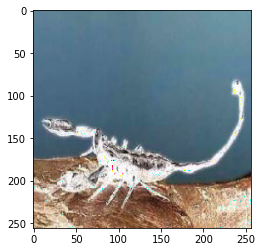

In [12]:
import matplotlib.pyplot as plt
tmp = torchvision.transforms.ToPILImage()(train_data[0][0].cpu())
plt.imshow(np.asarray(tmp))

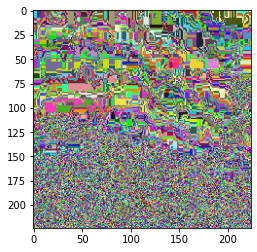

In [13]:
tmp = torchvision.transforms.ToPILImage()(preprocess(train_data[0][0].cpu()))
plt.imshow(np.asarray(tmp))

# 학습

In [14]:
# pretrained_model = torchvision.models.vgg19(pretrained = True).cuda()
pretrained_model = torchvision.models.resnet18(pretrained = True).cuda()

for param in pretrained_model.parameters():
    param.requires_grad = False
print(pretrained_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
linear1 = torch.nn.Linear(1000, 256).cuda()
linear2 = torch.nn.Linear(256, 128).cuda()
linear3 = torch.nn.Linear(128, 102).cuda()

torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)

relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=0.2)

model = torch.nn.Sequential(pretrained_model, #AvgPool,  
                            linear1,relu, dropout,
                            linear2, relu,dropout,
                           linear3).cuda()

In [16]:
loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for epoch in range(100):
    model.train()
    avg_cost = 0
    for data in train_loader:
        #X, Y = data[0].cuda(), data[1].cuda()
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, avg_cost / n_batch)

1 3.767024712637067
2 2.112442341943582
3 1.5577137886236112
4 1.3388470492015283
5 1.129792128611977
6 0.9705571589681009
7 0.9464046506521603
8 0.9097136569519838
9 0.7910328205131615
10 0.7423803302614639
11 0.6894207937875763
12 0.679176273328873
13 0.6218599247707365
14 0.6443455084421051
15 0.5782271148636937
16 0.5649297077907249
17 0.6197914546646643
18 0.5095462692261208
19 0.5106994135421701
20 0.5199443667758411
21 0.5125479758523094
22 0.5487052495688355
23 0.46742251864634454
24 0.41335781751937856
25 0.4781201149847523
26 0.45396732312898774
27 0.4809308233282839
28 0.44336376477925415
29 0.4290882999024082
30 0.4314117020385311
31 0.4569465671277915
32 0.42288664783457836
33 0.44819845477953396
34 0.39063992236818496
35 0.3720803958070367
36 0.39939221481169324
37 0.41468537794692867
38 0.40932463968541316
39 0.378184633475333
40 0.45144082827391685
41 0.40628403819937375
42 0.4255409860209814
43 0.3874239439804417
44 0.40737381585131516
45 0.2956944534480499
46 0.291841

In [17]:
y_pred = []
with torch.no_grad():
    model.eval()
    for data in test_loader:
        xx = data[0].cuda()
        pred = torch.argmax(model(preprocess(xx)),1)
        pred = pred.cpu().detach().numpy()
        y_pred.extend(pred)
        
y_pred = np.array(y_pred)

submit = pd.read_csv("/kaggle/input/2021-ai-w11-p1/submission.csv")
submit['Category'] = y_pred + 1
submit.to_csv("submission1.csv", mode ="w", index= False)

In [18]:
torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)

relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=0.2)

model = torch.nn.Sequential(pretrained_model, #AvgPool,  
                            linear1,relu, dropout,
                            linear2, relu,dropout,
                           linear3).cuda()

loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5)

for epoch in range(100):
    model.train()
    avg_cost = 0
    for data in train_loader:
        #X, Y = data[0].cuda(), data[1].cuda()
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, avg_cost / n_batch)
    
    scheduler.step(cost)

1 3.7499433470269046
2 2.1279157704363265
3 1.5910231014713645
4 1.2938408569122355
5 1.0686925247622032
6 0.993182482663542
7 0.9037455443758518
8 0.8144504334001491
9 0.7741358682590848
10 0.7667771013608823
11 0.6711458998615853
12 0.6636116151154662
13 0.6074398669879884
14 0.6445507147194197
15 0.598627842652301
16 0.5295495317744402
17 0.5335360275736699
18 0.5774091815692373
19 0.5808098977043604
20 0.49030918391266215
21 0.43969312170520425
22 0.4352410979166355
23 0.47512110516739386
24 0.5175290150897732
25 0.44691826240644633
26 0.39307228037311387
27 0.46543673289124854
28 0.4709411322255619
29 0.4518676216963892
30 0.417497701952622
31 0.4020991270311545
32 0.3996818966358357
33 0.4018871029499375
34 0.30020761570631294
35 0.26875058057278994
36 0.2263094884080298
37 0.21534194356233152
38 0.22708816065429951
39 0.20226694335451612
40 0.20411862904135583
41 0.2124988939394825
42 0.22181116078778965
43 0.20489424404422607
44 0.20787470775834058
45 0.18505778509825177
46 0.1

In [19]:
y_pred = []
with torch.no_grad():
    model.eval()
    for data in test_loader:
        xx = data[0].cuda()
        pred = torch.argmax(model(preprocess(xx)),1)
        pred = pred.cpu().detach().numpy()
        y_pred.extend(pred)
        
y_pred = np.array(y_pred)

submit = pd.read_csv("/kaggle/input/2021-ai-w11-p1/submission.csv")
submit['Category'] = y_pred + 1
submit.to_csv("submission2.csv", mode ="w", index= False)

In [20]:
linear1 = torch.nn.Linear(1000, 512).cuda()
linear2 = torch.nn.Linear(512, 512).cuda()
linear4 = torch.nn.Linear(512, 128).cuda()
linear5 = torch.nn.Linear(128, 128).cuda()
linear3 = torch.nn.Linear(128, 102).cuda()


torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)
torch.nn.init.xavier_normal_(linear4.weight)
torch.nn.init.xavier_normal_(linear5.weight)

relu = torch.nn.ReLU()
# AvgPool = torch.nn.AdaptiveAvgPool1d(512)
dropout = torch.nn.Dropout(p=0.2)

model = torch.nn.Sequential(pretrained_model, #AvgPool,  
                            linear1,relu, dropout,
                            linear2, relu,dropout,

                            linear4, relu,dropout,
                            linear5, relu,dropout,

                           linear3).cuda()

In [21]:
loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for epoch in range(100):
    model.train()
    avg_cost = 0
    for data in train_loader:
        #X, Y = data[0].cuda(), data[1].cuda()
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, avg_cost / n_batch)
    


1 4.376575668652852
2 3.277958627169331
3 2.62651685004433
4 2.2534203163037696
5 1.874758164708813
6 1.7144703323331971
7 1.4913478894159198
8 1.3606736577736835
9 1.2855851207859814
10 1.1705698318158586
11 1.168614718131721
12 1.0649529835985352
13 0.9987638307114443
14 1.0010557503749926
15 0.8661315191614752
16 0.8830526456392059
17 0.8832495856719712
18 0.7863147100821758
19 0.8278615289212515
20 0.7555747060881307
21 0.6915917332516983
22 0.7146544127026573
23 0.7390049505532564
24 0.633550080897597
25 0.708222065877635
26 0.6152554748696275
27 0.6269971980946139
28 0.6543040835531428
29 0.6677751014455376
30 0.6196040608362333
31 0.5585045442761233
32 0.5617336685948734
33 0.5739558718293362
34 0.5671735153009649
35 0.5287067538884003
36 0.5756433811620809
37 0.600675637627622
38 0.4925451026016769
39 0.6121103825571481
40 0.5201566319738049
41 0.5118148337399665
42 0.4676244790753117
43 0.4862070636736462
44 0.45033444937022676
45 0.47863323125663254
46 0.4787348483174962
47 0

In [22]:
y_pred = []
with torch.no_grad():
    model.eval()
    for data in test_loader:
        xx = data[0].cuda()
        pred = torch.argmax(model(preprocess(xx)),1)
        pred = pred.cpu().detach().numpy()
        y_pred.extend(pred)
        
y_pred = np.array(y_pred)

submit = pd.read_csv("/kaggle/input/2021-ai-w11-p1/submission.csv")
submit['Category'] = y_pred + 1
submit.to_csv("submission3.csv", mode ="w", index= False)

In [23]:
torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)
torch.nn.init.xavier_normal_(linear4.weight)
torch.nn.init.xavier_normal_(linear5.weight)

relu = torch.nn.ReLU()
# AvgPool = torch.nn.AdaptiveAvgPool1d(512)
dropout = torch.nn.Dropout(p=0.2)

model = torch.nn.Sequential(pretrained_model, #AvgPool,  
                            linear1,relu, dropout,
                            linear2, relu,dropout,

                            linear4, relu,dropout,
                            linear5, relu,dropout,

                           linear3).cuda()

loss = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5)

for epoch in range(100):
    model.train()
    avg_cost = 0
    for data in train_loader:
        #X, Y = data[0].cuda(), data[1].cuda()
        X, Y = data[0], data[1]
        h = model(preprocess(X))
        cost = loss(h, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        avg_cost += cost.item()
    print(epoch+1, avg_cost / n_batch)
    
    scheduler.step()

1 4.351960465312004
2 3.1776655359814563
3 2.499631065875292
4 2.155936318139235
5 1.8892600185548265
6 1.6717538473506768
7 1.482317680803438
8 1.3632229088495176
9 1.3095870148390532
10 1.1925164740532637
11 0.9483716348186135
12 0.8429677901246274
13 0.7366823525711274
14 0.7422496307408437
15 0.6640481452923268
16 0.6571843499938647
17 0.6238903205570144
18 0.5308132536786919
19 0.5526920847187284
20 0.5320647192420438
21 0.4271992458719372
22 0.4074946309022683
23 0.35897623938702355
24 0.38325510238549515
25 0.33098368588737986
26 0.3397083188756369
27 0.3103492273997593
28 0.3240636458795052
29 0.30750933130912017
30 0.28982636210760876
31 0.2681825278705219
32 0.24327289802992405
33 0.23419535746991946
34 0.247780826241069
35 0.22934120618629095
36 0.24054891094419872
37 0.21532471058192945
38 0.21568235236190958
39 0.22821166626332948
40 0.2099380228391965
41 0.20755135741759054
42 0.211750430335087
43 0.1900810980108266
44 0.18066966249474112
45 0.19055008843982554
46 0.16146

In [24]:
y_pred = []
with torch.no_grad():
    model.eval()
    for data in test_loader:
        xx = data[0].cuda()
        pred = torch.argmax(model(preprocess(xx)),1)
        pred = pred.cpu().detach().numpy()
        y_pred.extend(pred)
        
y_pred = np.array(y_pred)

submit = pd.read_csv("/kaggle/input/2021-ai-w11-p1/submission.csv")
submit['Category'] = y_pred + 1
submit.to_csv("submission4.csv", mode ="w", index= False)